In [46]:
# To help you get started...
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.ar_model import AutoReg

In [47]:
data = pd.read_csv('exampleco_data/machine_1.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data["date"]= pd.to_datetime(data["date"])

In [48]:
data_columns = data.loc[:, data.columns != 'date'].columns
data_columns

Index(['0', '1', '2', '3'], dtype='object')

In [49]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [50]:
data_parseDate = data.set_index('date')

In [51]:
data_parseDate.head()

,0,1,2,3
date,,,,
2019-01-01 00:00:00.000000000,12.588243,8.829718,-11.803474,10.083107
2019-01-01 08:00:09.603201067,10.822199,2.795246,11.560279,21.898688
2019-01-01 16:00:19.206402134,21.074661,-0.655051,-17.840580,-1.346748
2019-01-02 00:00:28.809603201,32.284431,6.544655,-13.498907,-4.281704
2019-01-02 08:00:38.412804268,28.073949,253.681988,271.983917,263.627071


# Making a function to find the index at which the machine fails to work

This is done by finding the first instance at which all the machines are at zeroes ie when the machines stops to work.

In [52]:
def stoppage_time_func(df):
    first_instance_index = 0
    
    data_copy = df.copy()
    
    if data_copy.index.name == 'date':
        data_copy.reset_index(inplace=True)
    
    data_copy_date = data_copy[['date']]
        
    data_copy.drop(['date'], axis=1, inplace=True)
    data_copy = data_copy.astype(int)
    first_instance_index = data_copy[data_copy.apply(pd.Series.nunique, axis=1) == 1].head(1).index[0]
    
    return first_instance_index, data_copy_date.iloc[first_instance_index:first_instance_index+1, :]['date'].values[0]

In [53]:
first_instance_index, first_instance_date  = stoppage_time_func(data_parseDate)

print("At index " + str(first_instance_index) + " ie at " + str(first_instance_date) + " the machine stops working !!")

At index 1738 ie at 2020-08-02T12:38:10.363454488 the machine stops working !!


# Setting different dataframes for each sensors

To learn about each sensors, we need to seperate the data into different dataframes.

In [54]:
# function to return power of each number
def power_df(df, pow_num):
    return df.pow(2, axis = 1)

In [55]:
# Copy of main dataframe
sensors_data = data_parseDate.copy()

# List of dataframes from sensor 0 to 3 each with values squared and date as index
sensors_sq_data = power_df(data_parseDate, 2)

# Creating visualizations to detect outliers
Since the sensors die out we get results almost equal to 0, the mean gets closer to zero and that's the reason for the IQR range becoming narrower. For the above reason, a function has been defined above which gives the index value of the first instance when all the sensors die out. This is because we now get the values when the machine was working.

In [56]:
def plot_boxplot(data, data_range):
    fig = go.Figure()

    sensor_data = data.copy()
    
    for col in sensor_data.columns:
        fig.add_trace(
            go.Box(
                y=sensor_data[[col]].iloc[:data_range,0].tolist(),
                boxpoints='outliers'
            )
        )

    fig.update_layout(height=600, width=920, title_text="Box Plots of the four sensors")
    fig.show()

In [57]:
def plot_timeseries(sensor_data):
    colors = ['r', 'g', 'b', 'orange']
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10))

    for i,ele in enumerate(sensor_data.columns):
        sensor_data[ele].plot(ax=axes[i], c=colors[i])
        
    fig.tight_layout(pad=2.0)

In [58]:
def change_outliers(num, l_b, u_b):
    if (num < l_b) or (num > u_b):
        return np.nan
    else:
        return num

In [59]:
def change_outliers_dataframes(main_df):
    sensors_lst = main_df.copy() 
    
    for col in sensors_lst:
        a = sensors_lst[col]
        upper_bound = a.mean() + (2 * a.std())
        lower_bound = a.mean() - (2 * a.std())

        sensors_lst[col] = sensors_lst[col].apply(lambda x: change_outliers(x, lower_bound, upper_bound))
        sensors_lst[col].ffill(axis=0, inplace=True)

    return sensors_lst

In [60]:
plot_boxplot(sensors_data, first_instance_index)

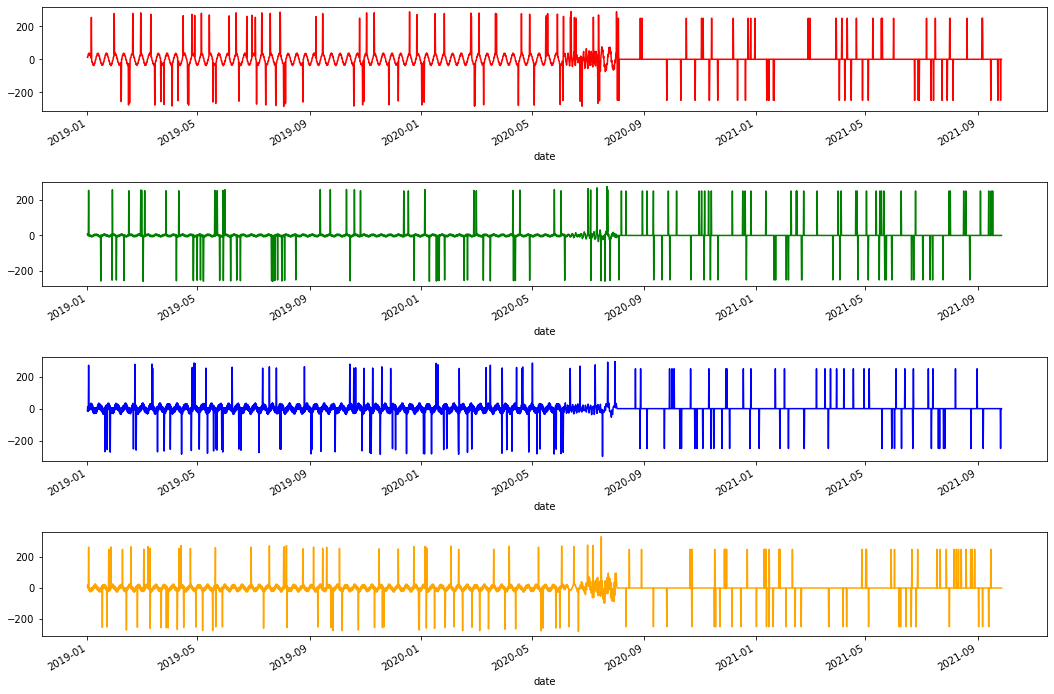

In [61]:
plot_timeseries(sensors_data)

By changing the value of the first_instance_index we get to see a lot of variations. An assumption can be made that the sensors 1 and 3 fluctuates a lot before the machine goes into the faulty period.
But for now, as we can see that we have got extreme outliers in out data and for each sensors we have outliers starting from 250 and above and -250 and below, we'll convert this outliers to np.nan and then use forward fill.

For squared data we'll select the square of 250

In [62]:
# Removing the outliers
sensors_data_clean = change_outliers_dataframes(sensors_data)
sensors_sq_data_clean = change_outliers_dataframes(sensors_sq_data)

In [63]:
sensors_data_clean.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [64]:
plot_boxplot(sensors_data_clean, first_instance_index)

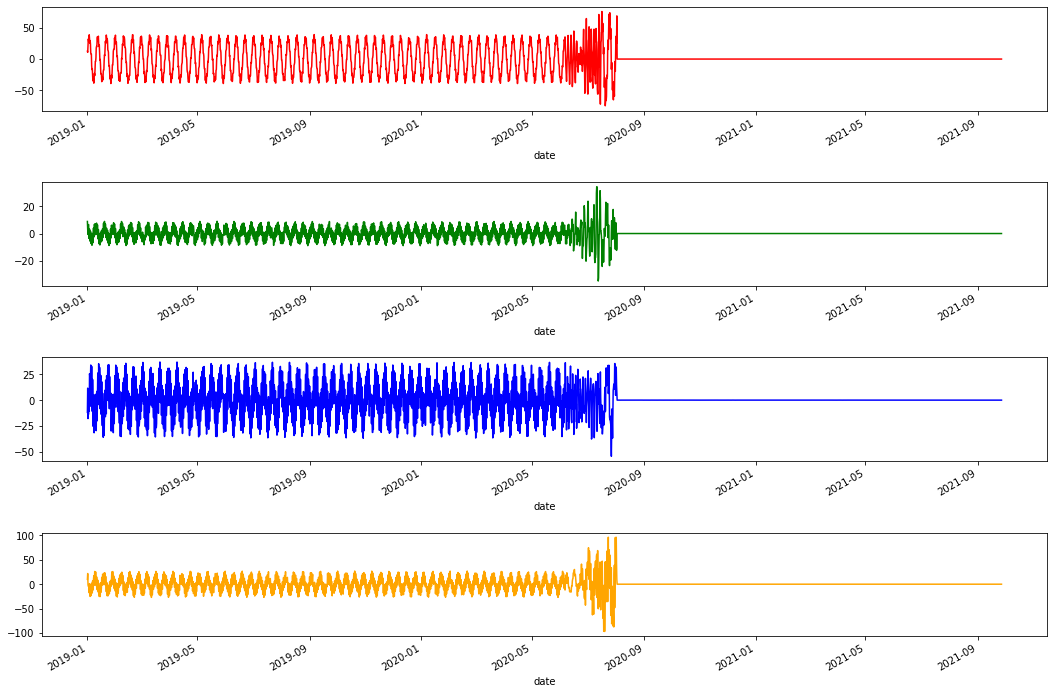

In [65]:
plot_timeseries(sensors_data_clean)

We can clearly see the stopping point of the sensors. And sensors 0,1 and 3 shows anomaly before the machine is about to fail. We can use this data to perform machine learning methods and check for any Anomaly detection.

In [66]:
# Function to split a dataset into training and testing
def train_test_split(df, percentage=60):    
    split_num = int((df.shape[0]*percentage)/100)
    train ,test = df[0:split_num], df[split_num:]
    return train, test

# Using AR model

In [67]:
# Function that returns a dataframe of the lags which has the lowest AIC and BIC
def auto_reg_funct(df, n):
    res_sum = {
        'lags':[],
        'AIC':[],
        'BIC':[]
    }
    
    for i in range(1, n+1):        
        res = AutoReg(df, lags = i).fit()
        res_sum['lags'].append(i),
        res_sum['AIC'].append(res.aic)
        res_sum['BIC'].append(res.bic)
        
    df_lagList = pd.DataFrame(res_sum)
    
    return df_lagList

In [68]:
def auto_reg_viz(data_df, percent_split):
    
    # Get a copy of the main data and remove the date which is the index
    sensors_lst = data_df.copy()
    sensors_lst = sensors_lst[:first_instance_index]
    
    sensors_lst.reset_index(inplace=True)
    x_date = sensors_lst[['date']]
    sensors_lst.drop(['date'], axis=1, inplace=True)
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10))
    percentage_to_split = percent_split

    for i,col in enumerate(sensors_lst.columns):
        # split the data into train and test
        train, test = train_test_split(sensors_lst[[col]], percentage_to_split)
        
#         print(test_start)
        
        # We'll find the minimum number of AIC lags required
        df_autoReg = pd.DataFrame(auto_reg_funct(train, 50))        
        min_AIC_lag = df_autoReg.sort_values(["AIC", "BIC"], ascending = (True, True)).head(1)['lags'].values[0]
        
        # Fitting and Predicting the data
        print("Sensor "+ col + " used "+ str(min_AIC_lag) + " lags")
        res = AutoReg(train, lags = min_AIC_lag).fit()
        predictions = res.predict(start=len(train), end=len(train)+len(test)-1)
        
        
        
        str_col_pred = str(col)+"_auto_reg_pred"
        sensors_lst[str_col_pred] = train[col].values.tolist() + predictions.values.tolist()
        
        train_index = x_date[:train.shape[0]]['date'].tolist()
        train.index = train_index
        train.index = pd.to_datetime(train.index)
        
        test_index = x_date[train.shape[0]:]['date'].tolist()        
        test.index = test_index
        test.index = pd.to_datetime(test.index)
        predictions = pd.DataFrame({col:predictions.values})
        predictions.index = test_index
        predictions.index = pd.to_datetime(predictions.index)
        
        test_start = test.head(1).index.values[0]

        # Plotting the data
        title = "Plot of predicted values VS the true values for sensor " + col + " has " + str(min_AIC_lag) + " lags."
        train.plot(color='orange', ax=axes[i], title=title)
        test.plot(color='orange', ax=axes[i], legend=None)
        predictions.plot(color='red', ax=axes[i], legend=None)
        axes[i].axvline(test_start, linestyle='--')
        
        axes[i].legend(["train", "test", "Predictions"])

        fig.tight_layout(pad=2.0)
        
        
    
    return sensors_lst

Sensor 0 used 33 lags
Sensor 1 used 45 lags
Sensor 2 used 44 lags
Sensor 3 used 49 lags


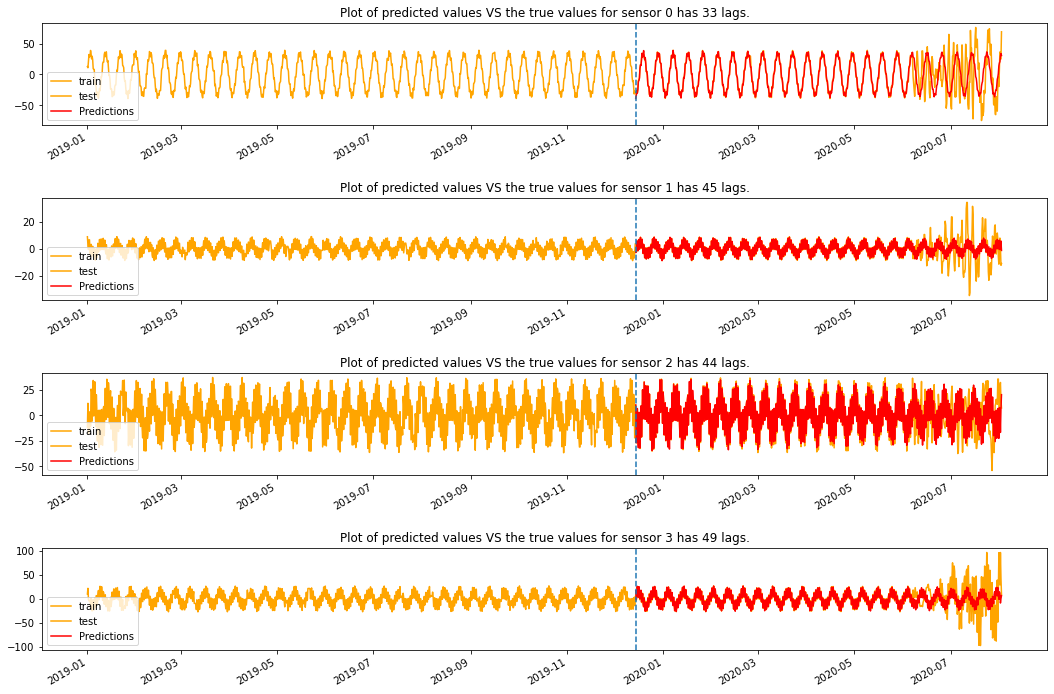

In [69]:
get_aut_reg_pred_df = auto_reg_viz(sensors_data_clean, 60)

Sensor 0 used 47 lags
Sensor 1 used 50 lags
Sensor 2 used 41 lags
Sensor 3 used 41 lags


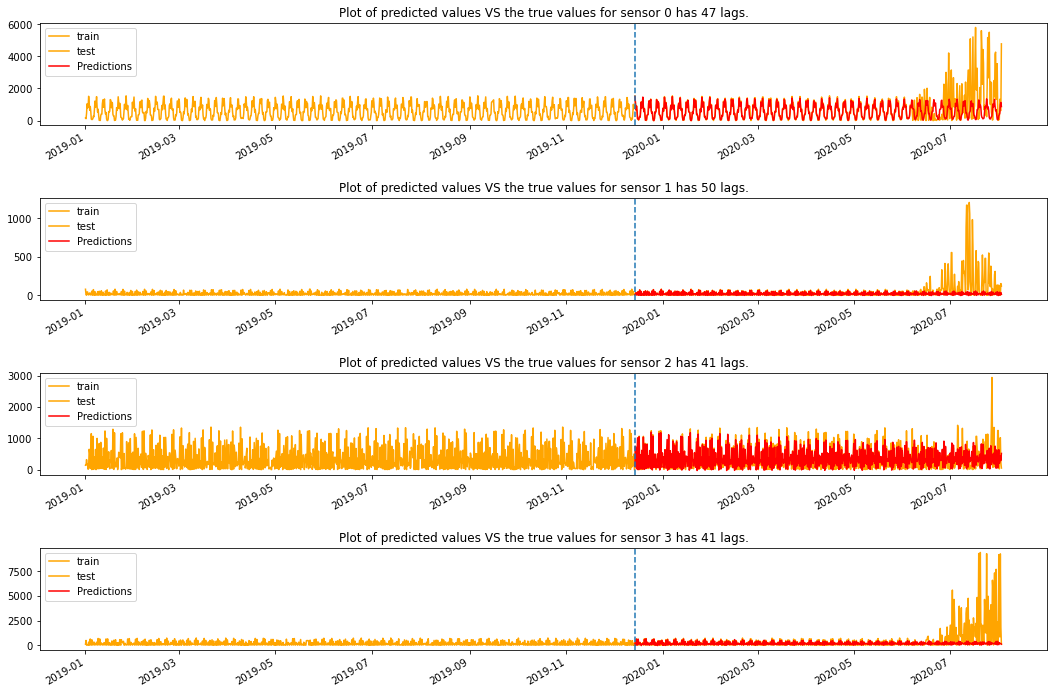

In [70]:
get_aut_reg_sq_pred_df = auto_reg_viz(sensors_sq_data_clean, 60)

We can use confidence interval in AR model to define the faulty period

# Using SVM model

In [71]:
from sklearn.svm import OneClassSVM
from numpy import quantile, where, random

In [92]:
def plot_anamolies(dataparse_df, stoppage_period, nu_frac, gamma_frac): 
    
    svm = OneClassSVM(kernel='rbf', nu=nu_frac, gamma=gamma_frac)
    
    main_sensor = dataparse_df
    x = main_sensor[:stoppage_period]
    
    svm.fit(x.values.tolist())
    pred = svm.predict(x.values.tolist())
    
    anom_index = [i for i, x in enumerate(pred) if x == -1]
    values = x.iloc[anom_index,:]
    
    fig = plt.figure(figsize=(10, 8))
    
    ax = main_sensor.plot(c='b',figsize=(15,5))
    values.plot(c='r', style='o', ax=ax, figsize=(15,5))
    
    ax.set_title('Anamoly detection for sensor: '+str(x.columns[0]))
    ax.legend(["original", "anamoly"])
    plt.show()

<Figure size 720x576 with 0 Axes>

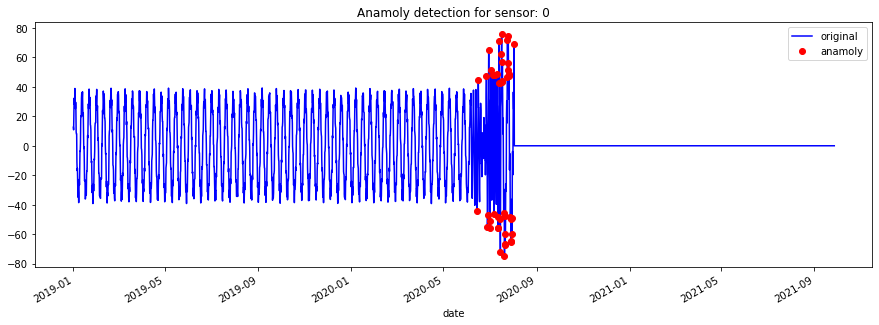

<Figure size 720x576 with 0 Axes>

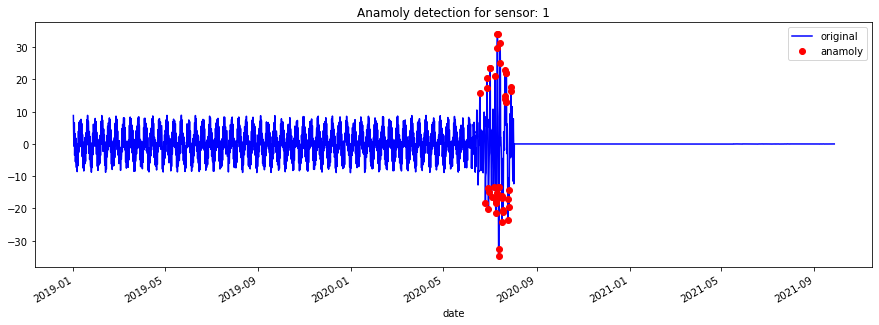

<Figure size 720x576 with 0 Axes>

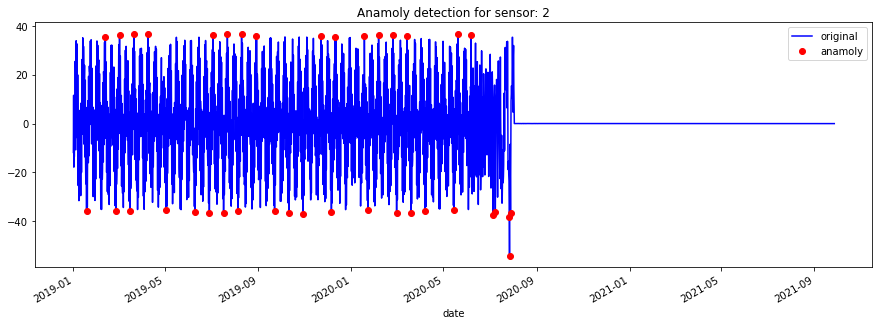

<Figure size 720x576 with 0 Axes>

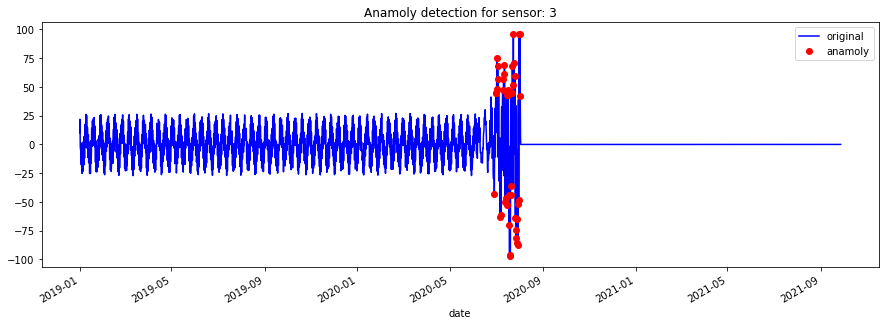

In [93]:
for col in sensors_data_clean.columns:
    plot_anamolies(sensors_data_clean[[col]], first_instance_index, 0.026, 0.000001)

### Improvement

    The model cannot properly predict the sensor 2 data. we can try the squared version of our data and see how the model works.

# AutoEncoders

In [94]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers
import datetime
import seaborn as sns

In [96]:
"""
This function returns the days from start we want.
time -> the number for days we want from the dataset
"""

def get_timeline(df, time=1):
#     month_period_index = time*30
    month_period = df.index[0] + datetime.timedelta(time)
    return df.loc[: month_period, : ], df.loc[month_period : , : ]

In [97]:
X = sensors_data_clean[:first_instance_index].copy()
train, test = get_timeline(X, 35)

In [98]:
train.shape, test.shape

((105, 4), (1633, 4))

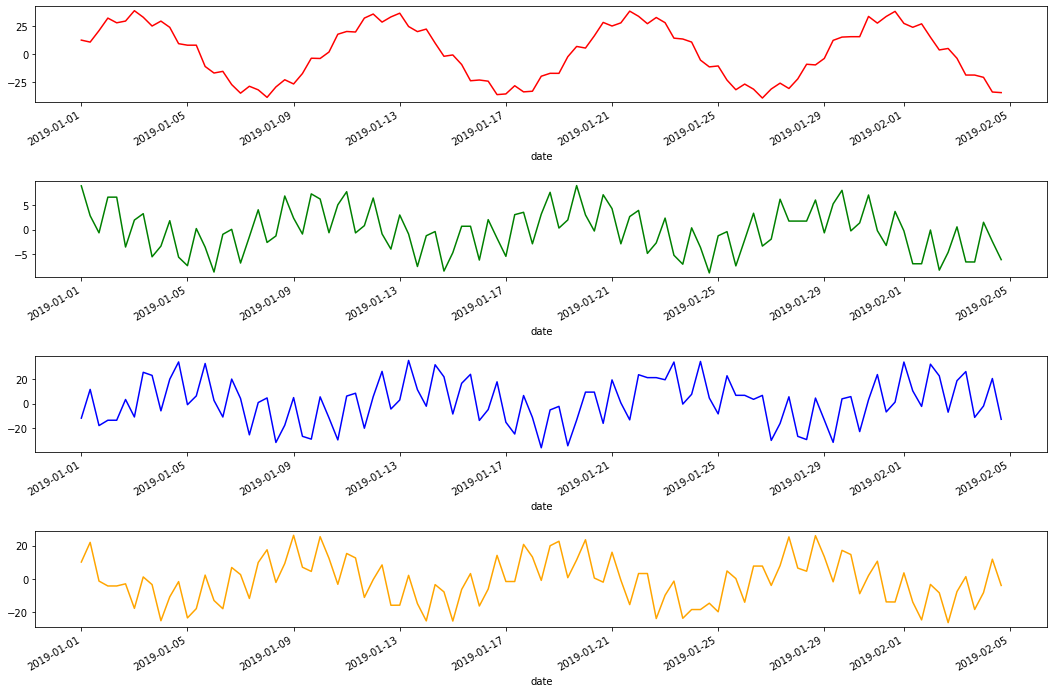

In [99]:
plot_timeseries(train)

In [100]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
train_fft_df = pd.DataFrame(data=train_fft, index=train.index, columns=train.columns)

test_fft = np.fft.fft(test)
test_fft_df = pd.DataFrame(data=test_fft, index=test.index, columns=test.columns)

In [101]:
# Scaling the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [102]:
# Reshapig the data

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (105, 1, 4)
Test data shape: (1633, 1, 4)


In [104]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [105]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)             

In [106]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
10/10 [==============================] - 0s 36ms/step - loss: 0.5062 - val_loss: 0.3775
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4950 - val_loss: 0.3657
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4836 - val_loss: 0.3536
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4722 - val_loss: 0.3410
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4604 - val_loss: 0.3296
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4482 - val_loss: 0.3186
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4357 - val_loss: 0.3067
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.2942
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4092 - val_loss: 0.2802
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.3949 - val_loss: 0.2682
Epoch 11

10/10 [==============================] - 0s 4ms/step - loss: 0.1909 - val_loss: 0.1651
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1914 - val_loss: 0.1633
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1905 - val_loss: 0.1652
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1909 - val_loss: 0.1652
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1909 - val_loss: 0.1646
Epoch 88/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1905 - val_loss: 0.1632
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1906 - val_loss: 0.1624
Epoch 90/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1906 - val_loss: 0.1639
Epoch 91/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1908 - val_loss: 0.1625
Epoch 92/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1905 - val_loss: 0.1620
Epoch 93/100


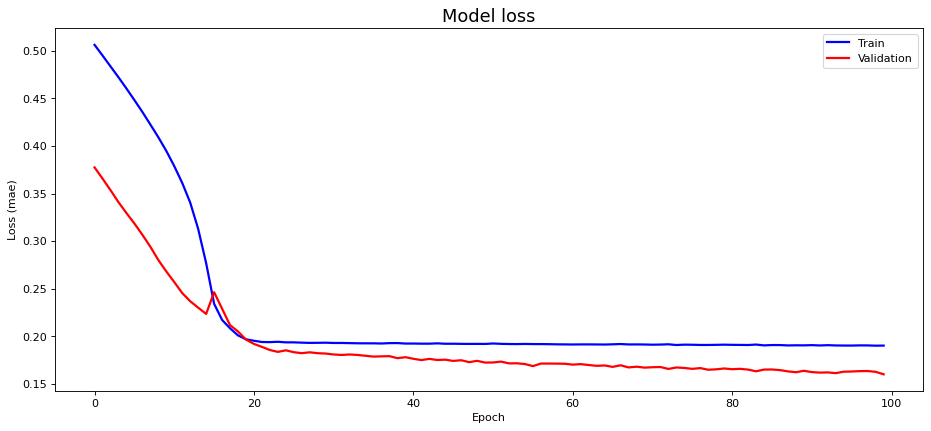

In [107]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

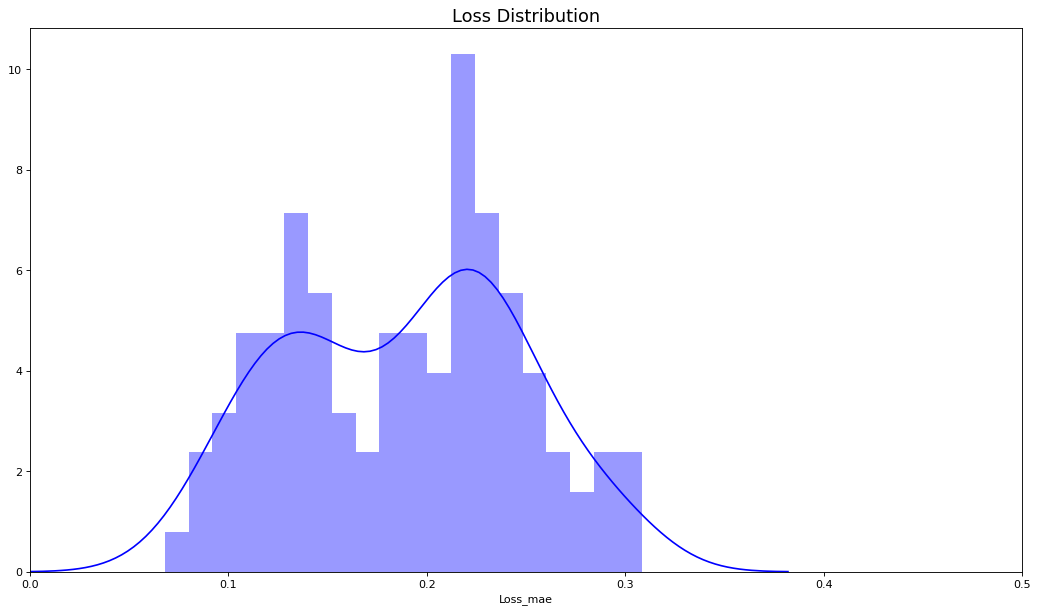

In [108]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [109]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.37 #---------------------------------------------------------threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored

,Loss_mae,Threshold,Anomaly
date,,,
2019-02-05 00:16:48.336112037,0.191192,0.37,False
2019-02-05 08:16:57.939313104,0.299053,0.37,False
2019-02-05 16:17:07.542514171,0.191519,0.37,False
2019-02-06 00:17:17.145715238,0.240760,0.37,False
2019-02-06 08:17:26.748916305,0.302313,0.37,False
2019-02-06 16:17:36.352117372,0.206410,0.37,False
2019-02-07 00:17:45.955318439,0.241274,0.37,False
2019-02-07 08:17:55.558519506,0.257387,0.37,False
2019-02-07 16:18:05.161720573,0.160704,0.37,False


In [110]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

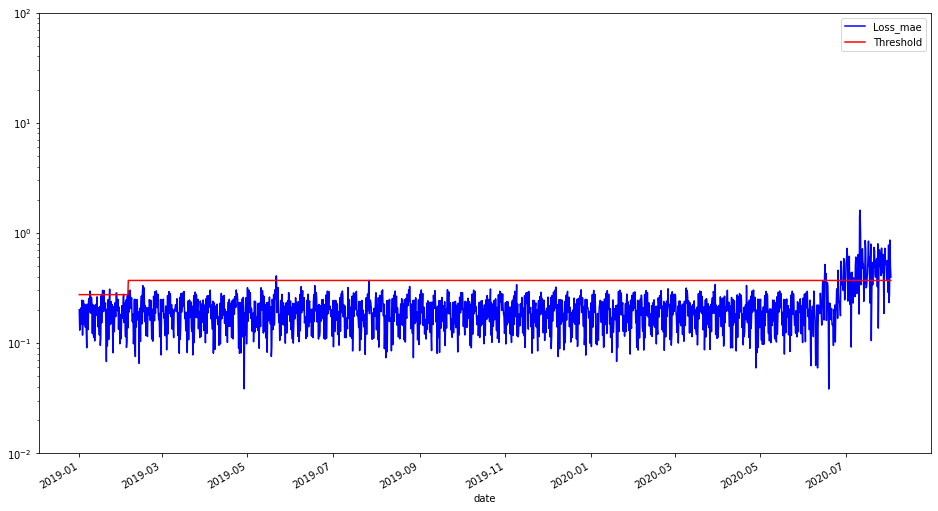

In [111]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

## IMPROVEMENTS

There are few .csv files which doesn't have any data i.e. for the machine to learn the pattern properly. For example the data in machine_3.csv starts with a faulty period.